In [1]:
import numpy as np
import pandas as pd
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
import category_encoders as ce 
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv", parse_dates=['fecha'])
val = pd.read_csv("test.csv", parse_dates=['fecha'])

In [3]:
#Iterative imputer en los valores faltantes
class MissingValuesImputer( BaseEstimator, TransformerMixin ):
      
    def __init__( self, features_to_impute ):
        self._features_to_impute = features_to_impute
        
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        imp = IterativeImputer(missing_values=np.nan, max_iter=30, random_state=42)
        X[features_to_impute] = imp.fit_transform(X[features_to_impute])
        return X

In [4]:
# Dropear columnas que no se usan
class DropFeatures( BaseEstimator, TransformerMixin ):
    
    def __init__( self, features_to_drop ):
        self._features_to_drop = features_to_drop 
      
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        for feat in self._features_to_drop:
            if feat in X.columns:
                X = X.drop(feat, axis=1)
        return X

In [5]:
#Encoder para las categorias
class CategoryEncoder( BaseEstimator, TransformerMixin ):
      
    def fit( self, X, y = None ):
        self.ciudad_te = ce.ordinal.OrdinalEncoder().fit(X['ciudad'], X['precio'])
        self.tipo_te = ce.ordinal.OrdinalEncoder().fit(X['tipodepropiedad'], X['precio'])
        self.prov_te = ce.ordinal.OrdinalEncoder().fit(X['provincia'], X['precio'])
        return self 
    
    def transform( self, X, y = None ):
        X['ciudad'] = self.ciudad_te.transform(X['ciudad'])
        X['tipodepropiedad'] = self.tipo_te.transform(X['tipodepropiedad'])
        X['provincia'] = self.prov_te.transform(X['provincia'])
        return X

In [6]:
#Tomo el año de las fechas
class DateTransformer( BaseEstimator, TransformerMixin ):
      
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        X['ano'] = X.fecha.dt.year
        X = X.drop('fecha',axis=1)
        return X

In [7]:
features_to_drop = ['lat','lng','direccion','idzona','id','titulo','descripcion','text','centroscomercialescercanos','escuelascercanas']

features_to_impute = ['gimnasio', 'usosmultiples', 'piscina', 'tipodepropiedad','ciudad','provincia',
                      'habitaciones','garages','banos','metroscubiertos','ano','metrostotales','antiguedad']

features_preprocessing_pipeline = Pipeline( steps =   [ ('drop', DropFeatures(features_to_drop)),
                                                        ('date_transformer',DateTransformer()),
                                                        ('category_encoder',CategoryEncoder()),
                                                        ('drop_target', DropFeatures(['precio'])),
                                                        ('missing_values_imputer',MissingValuesImputer(features_to_impute))
                                                       ] )

In [8]:
train_df , test_df = train_test_split(train, test_size=0.2)

In [9]:
y_train = train_df.precio
y_test = test_df.precio

In [10]:
%%time
X_train = features_preprocessing_pipeline.fit_transform(train_df)

Wall time: 11.6 s


In [11]:
%%time
X_test = features_preprocessing_pipeline.transform(test_df)

Wall time: 2.32 s


In [12]:
%%time
val_prep = features_preprocessing_pipeline.transform(val)

Wall time: 3.06 s


# Modelos

# NN

In [13]:
X_train.columns

Index(['tipodepropiedad', 'ciudad', 'provincia', 'antiguedad', 'habitaciones',
       'garages', 'banos', 'metroscubiertos', 'metrostotales', 'gimnasio',
       'usosmultiples', 'piscina', 'ano'],
      dtype='object')

In [14]:
from keras.layers import Dense, Dropout, Input, Embedding,Reshape, Concatenate
from keras.models import Model
from keras import optimizers
import keras
from keras.utils import plot_model

Using TensorFlow backend.


In [15]:
cat_vars = ['tipodepropiedad','provincia','gimnasio','usosmultiples', 'piscina','ciudad']
cont_vars = ['antiguedad', 'habitaciones','garages', 'banos', 'metroscubiertos', 'metrostotales', 'ano']

ss = StandardScaler().fit(X_train[cont_vars])
X_train[cont_vars] = ss.transform(X_train[cont_vars])
X_test[cont_vars] = ss.transform(X_test[cont_vars])
val_prep[cont_vars] = ss.transform(val_prep[cont_vars])

x_train = []
x_val = []
x_subm = []
x_train.append(X_train[cont_vars].astype('float32').values)
x_val.append(X_test[cont_vars].astype('float32').values)
x_subm.append(val_prep[cont_vars].astype('float32').values)
for cat in cat_vars:
    x_train.append(X_train[cat].values)
    x_val.append(X_test[cat].values)
    x_subm.append(val_prep[cat].values)
    
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = X_train[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

In [16]:
ins = []
concat = []

In [17]:
y = Dropout(0.2, input_shape=(len(cat_vars)+len(cont_vars),))
y = Input((len(cont_vars),), name='cont_vars')
ins.append(y)
concat.append(y)

In [18]:
for cat in cat_vars:
    x = Input((1,), name=cat)
    ins.append(x)
    x = Embedding(cat_sizes[cat]+1, cat_embsizes[cat], input_length=1)(x)
    x = Reshape((cat_embsizes[cat],))(x)
    concat.append(x)

In [19]:
y = Concatenate()(concat)
y = Dropout(0.2)(y)
y = Dense(1024, activation= 'relu')(y)
y = Dropout(0.1)(y)
y = Dense(1024, activation= 'relu')(y)
y = Dropout(0.1)(y)
y = Dense(512, activation= 'relu')(y)
y = Dropout(0.2)(y)
y = Dense(256, activation= 'relu')(y)
y = Dense(1)(y)
model = Model(ins, y)

adam = keras.optimizers.Adam(learning_rate=0.0007)
model.compile(adam, 'mean_absolute_error')

In [20]:
model.summary ()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tipodepropiedad (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
provincia (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
gimnasio (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
usosmultiples (InputLayer)      (None, 1)            0                                            
____________________________________________________________________________________________

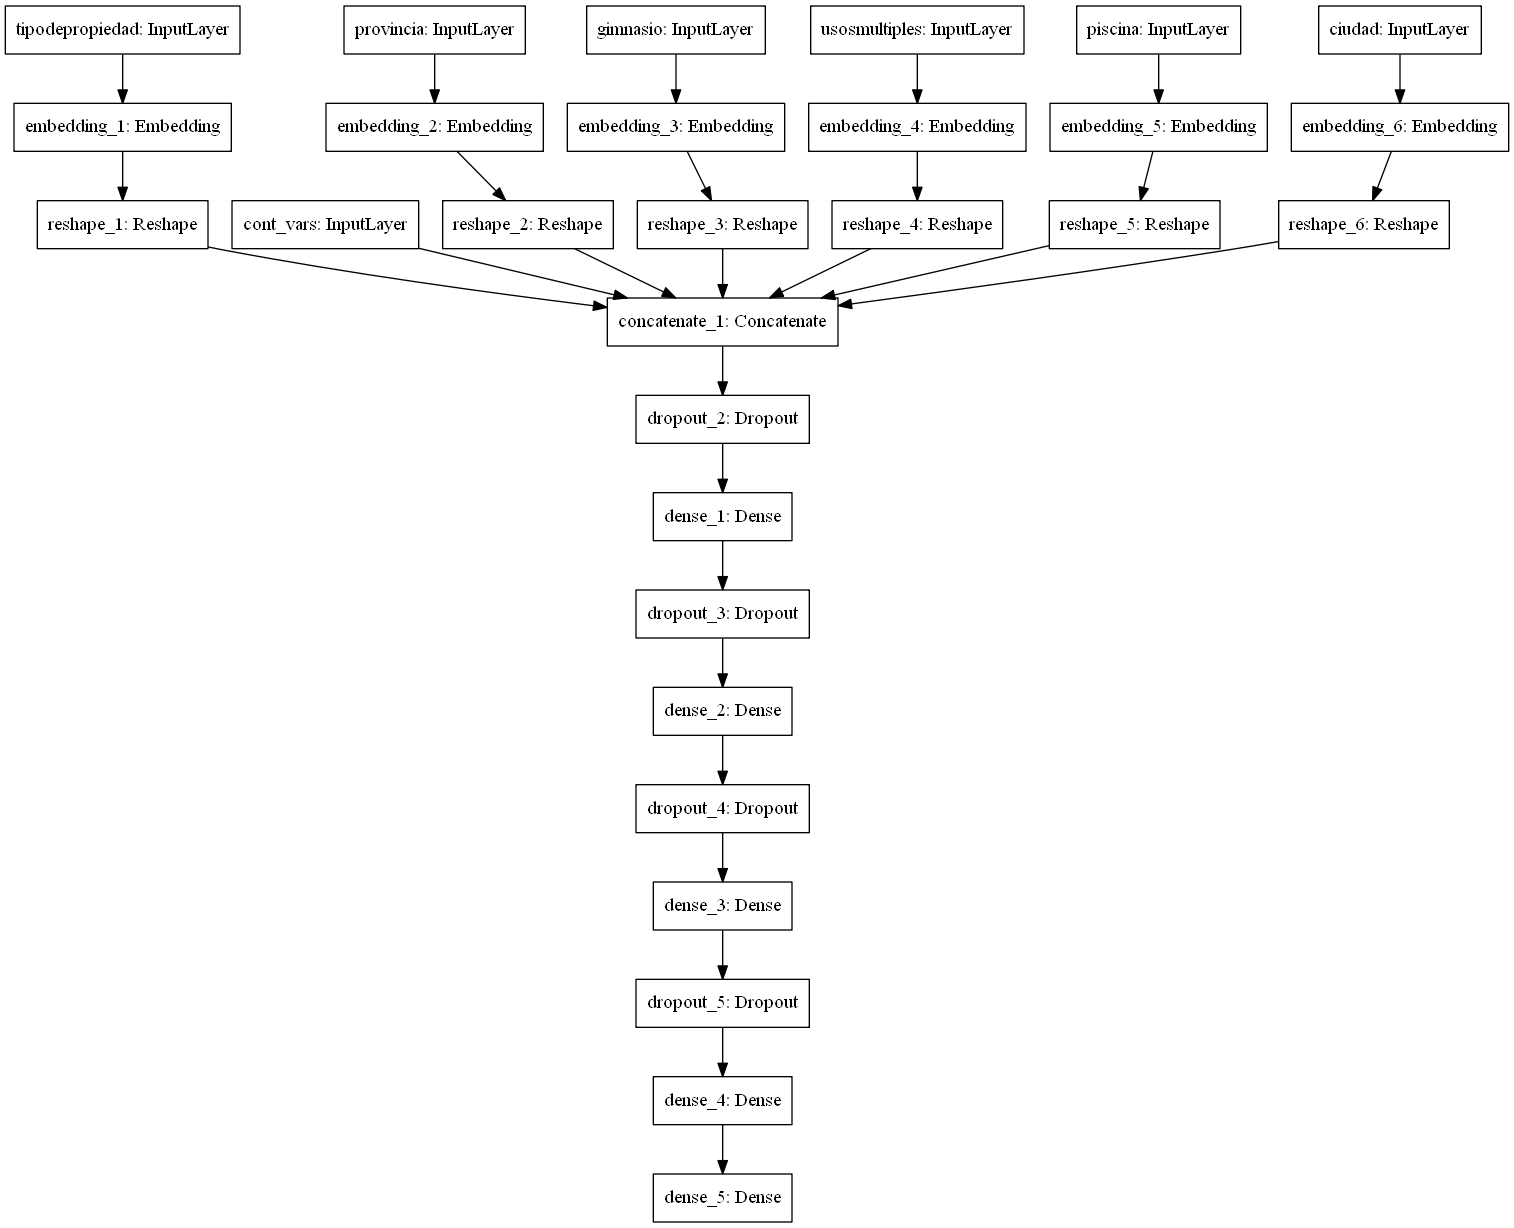

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [22]:
%%time
model.fit(x_train, y_train, 
          batch_size= 512, 
          epochs = 100, 
          validation_data=(x_val, y_test),
          callbacks=[keras.callbacks.EarlyStopping(patience=18)])

Train on 192000 samples, validate on 48000 samples
Epoch 1/100
191488/192000 [============================>.] - ETA: 0s - loss: 1206498.1113

InvalidArgumentError:  indices[185,0] = -1 is not in [0, 834)
	 [[node embedding_6/embedding_lookup (defined at C:\Users\fedeb\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_2829]

Function call stack:
keras_scratch_graph


In [23]:
subm_preds = model.predict(x_subm).ravel()
subm = pd.DataFrame({'id':val.id, 'target':subm_preds.ravel()})
subm.to_csv("NN_sin_nlp_subm.csv", index=False)

InvalidArgumentError:  indices[7,0] = -1 is not in [0, 834)
	 [[node embedding_6/embedding_lookup (defined at C:\Users\fedeb\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_7115]

Function call stack:
keras_scratch_graph
